In [18]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import time
import random
from numpy.random import multivariate_normal as randN
from tqdm import tqdm
%matplotlib inline

## Defining Counterexample

In [17]:
def counter_posterior(x, data):
    mean1 = np.array([-8, 0])
    cov1 = np.array([[0.5,0],[0,0.5]], dtype=np.float32)
    mean2 = np.array([8, 0])
    cov2 = np.array([[2,0],[0,2]], dtype=np.float32)
    res = 0
    res += np.exp(-0.5*(x-mean1).T@np.linalg.inv(cov1)@(x-mean1))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov1))/2
    res += np.exp(-0.5*(x-mean2).T@np.linalg.inv(cov2)@(x-mean2))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov2))
    return np.log(res)

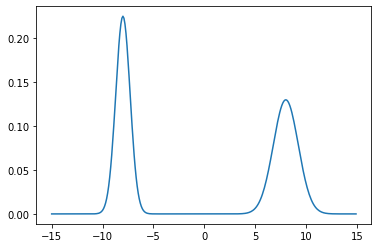

In [13]:
res = []
for x in np.arange(-15.0,15.0,0.1):
    res.append(counter_posterior(np.array([x, 0]), 1))
plt.plot(np.arange(-15.0,15.0,0.1), np.exp(res))

## MH Stuff

In [14]:
# compute autocorrelation at dimension dim
def autocorrelation(samples, dim, max_lag):
    x_j = samples[:, dim]
    tmp = x_j - np.mean(x_j)
    C_0 = np.sum(tmp**2)
    auto_correlation = np.correlate(tmp, tmp, "same")
    auto_correlation = auto_correlation / C_0
    # auto correlation is symmetric
    init = int((len(auto_correlation)/2))
    return auto_correlation[init:init+max_lag]
 
# plot autocorrelation 
def plot_autocorr(samples, max_lag=200, y_max = 0.2, y_min = -0.1):
    n, d = samples.shape
    for dim in range(d):
        A = autocorrelation(samples, dim, max_lag)
        label_dim = "dim = " + str(dim)
        plt.plot(A, label=label_dim)
    plt.title('Auto-correlation for all dimensions in the sample')    
    plt.xlabel('lag')
    plt.ylim((y_min, y_max))
    plt.ylabel('Auto-correlation')
    plt.legend()
    plt.show()

In [15]:
def prior(params):
    return 1

#Defines whether to accept or reject the new sample
def acceptance(log_pi, log_pi_new, proposal_ratio=1):
    accept=np.random.uniform(0,1)
    # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
    # less likely x_new are less likely to be accepted
    acc_ratio = np.exp(log_pi_new-log_pi)*proposal_ratio
    sig = 0
    if accept < acc_ratio:
        sig = 1
    if acc_ratio > 1:
        acc_ratio = 1
    return sig, acc_ratio

## Hand Tuned Ground truth

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:31<00:00, 6587.88it/s]


Density of the samples:


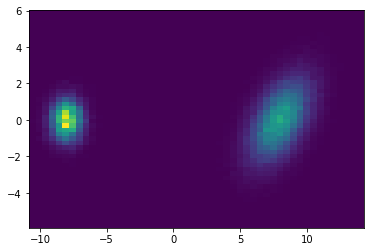

Average acceptance ratio is: 0.13435


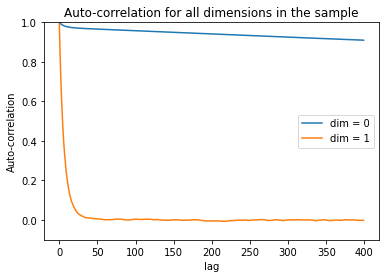

histogram along dim 0:


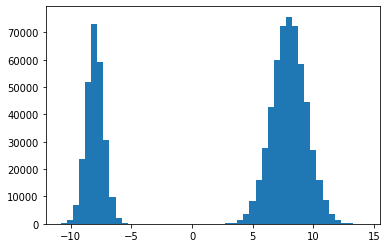

histogram along dim 1:


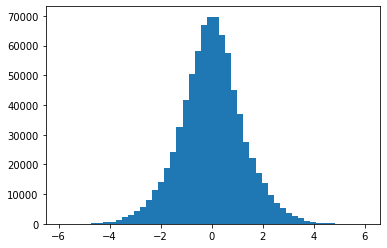

In [16]:
def Vanilla_MH(likelihood_computer, prior, x_init, iterations, burn_in, data, acceptance_rule):
    x = x_init
    d = len(x_init)
    samples = []; accepted = []
    # initialize covariance sigma to be identity matrix
    sigma = 15 * np.identity(d)
    accept_acc = 0
    for i in tqdm(range(iterations)):
        x_new = randN(x, sigma)
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data)
        # MH step
        sig, acc_ratio = acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))
        if sig:            
            x = x_new
        if i >= burn_in:
            samples.append(x)
            if sig == 1:
                accept_acc += 1
        # report all the accepted states as well
        accepted.append(x)
    # average acceptance ratio
    avg_acc = accept_acc / (iterations - burn_in)
    return np.array(samples), avg_acc, np.array(accepted) 

samples_MH, avg_acc, accepted_MH = Vanilla_MH(counter_posterior, prior, [-8, 0], 1000000, 200000, [], acceptance)
print("Density of the samples:")
plt.hist2d(samples_MH[:,0], samples_MH[:,1], bins=50)
plt.show()
print("Average acceptance ratio is:", avg_acc)
plot_autocorr(samples_MH, max_lag=400, y_max = 1, y_min = -0.1)
print("histogram along dim 0:")
plt.hist(samples_MH[:,0], bins=50)
plt.show()
print("histogram along dim 1:")
plt.hist(samples_MH[:,1], bins=50)
plt.show()

## Counterexample on Vanilla Adaptive MH

In [60]:
# Vanilla AM, Algorithm 2 in "a tutorial on adatpive mcmc"
# mu:       intermediate variable for adaptation
# sigma:    covariance matrix for SRWN, with proposal probability P_SRWN = N(0, 2.38**2/d)
# gamma:    stepsize 
# Returns:  1) new mu, 2) new sigma
def update_Vanilla_AM(x, mu, sigma, gamma):
    tmp = np.array(x) - mu
    new_mu = mu + gamma * tmp
    new_sigma = sigma + gamma * (np.outer(tmp, tmp) - sigma)
    return new_mu, new_sigma

def Vanilla_AM(likelihood_computer, prior, x_init, iterations, burn_in,
               data, acceptance_rule, gamma = 0.01):
    x = x_init
    d = len(x_init)
    samples = []; accepted = []
    # initialize covariance sigma to be identity matrix
    sigma = np.identity(d)
    mu = 1e-4 * np.ones(d)
    accept_acc = 0
    for i in tqdm(range(iterations)):
        cov = 2.38**2/d * sigma
        x_new = randN(x, cov)
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data)
        # MH step
        sig, acc_ratio = acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))
        if sig:            
            x = x_new
        if i >= burn_in:
            samples.append(x)
            if sig == 1:
                accept_acc += 1
        mu, sigma = update_Vanilla_AM(x, mu, sigma, gamma)
        # report all the accepted states as well
        accepted.append(x)
    # average acceptance ratio
    avg_acc = accept_acc / (iterations - burn_in)
    return np.array(samples), avg_acc, np.array(accepted)

### Initialization 1

100%|██████████| 10000/10000 [00:06<00:00, 1549.35it/s]


Density of the samples:


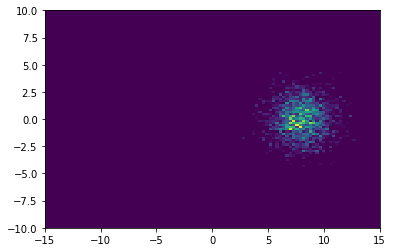

Average acceptance ratio is: 0.3836


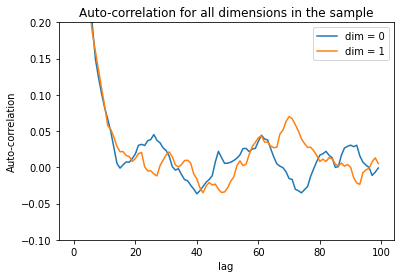

histogram along dim 0:


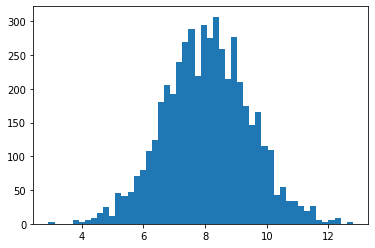

histogram along dim 1:


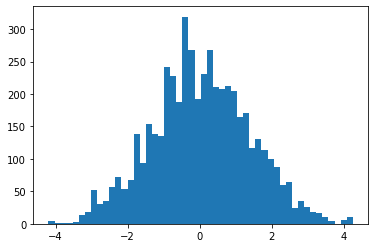

In [85]:
samples_AM, avg_acc, accepted_AM = Vanilla_AM(counter_posterior, prior, [8, 0], 10000, 5000, [], acceptance)
print("Density of the samples:")
plt.hist2d(samples_AM[:,0], samples_AM[:,1], bins=100, range=[[-15, 15], [-10, 10]])
plt.show()
print("Average acceptance ratio is:", avg_acc)
plot_autocorr(samples_AM, max_lag=100)
print("histogram along dim 0:")
plt.hist(samples_AM[:,0], bins=50)
plt.show()
print("histogram along dim 1:")
plt.hist(samples_AM[:,1], bins=50)
plt.show()

### Initialization 2

100%|██████████| 10000/10000 [00:06<00:00, 1522.57it/s]


Density of the samples:


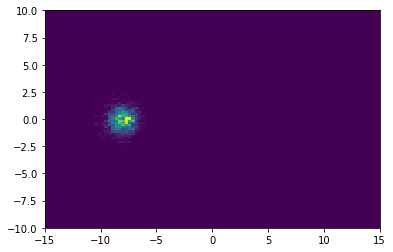

Average acceptance ratio is: 0.3646


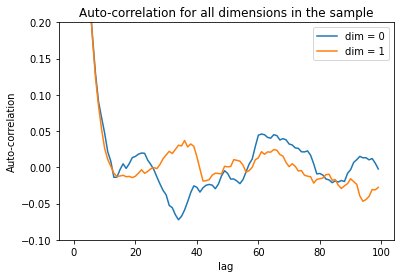

histogram along dim 0:


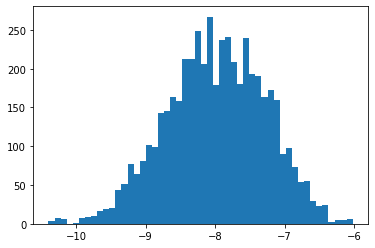

histogram along dim 1:


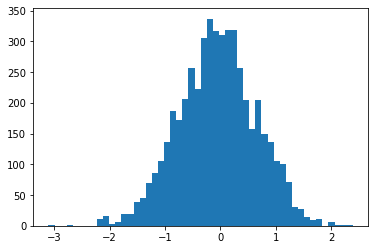

In [86]:
samples_AM, avg_acc, accepted_AM = Vanilla_AM(counter_posterior, prior, [-8, 0], 10000, 5000, [], acceptance)
print("Density of the samples:")
plt.hist2d(samples_AM[:,0], samples_AM[:,1], bins=100, range=[[-15, 15], [-10, 10]])
plt.show()
print("Average acceptance ratio is:", avg_acc)
plot_autocorr(samples_AM, max_lag=100)
print("histogram along dim 0:")
plt.hist(samples_AM[:,0], bins=50)
plt.show()
print("histogram along dim 1:")
plt.hist(samples_AM[:,1], bins=50)
plt.show()